## Predirre se qualcuno ha o non ha il Covid-19

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Antonelli Giacomo

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron

# Parte 1 - Descrizione del dataset e l'obiettivo del modello

Il [dataset scelto](https://www.kaggle.com/datasets/meirnizri/covid19-dataset?resource=download) contiene diverse informazioni riguardo la salute di numerosi pazienti che hanno contratto il virus del COVID-19, e del livello di rischio a cui ognuno di essi è sottoposto, ovvero quanto gravi sono stati gli effetti sul loro corpo (colonna CLASSIFICATION_FINAL). Il modello avrà lo scopo di definire se il paziente è o meno malato di COVID, basandosi solamente sulle informazioni cliniche, applicato al mondo reale questo modello verrebbe usato per capire preventivamente se un soggetto ha buone probabilità di essere malato, e quindi isolarlo in modo che non contagi altre persone e inoltre, fornirgli le cure adeguate per tempo in modo da aumentare le sue possibilità.

Il dataset in sé contiene 1.048.576 righe (una per ogni paziente) e 21 caratteristiche elencate qui di seguito:
- sex: 1 per le femmine e 2 per i maschi.
- age: età del paziente.
- classification: risultati del test covid. I valori da 1 a 3 significano che il paziente è stato diagnosticato con covid in diversi gradi. 4 o superiore significa che il paziente non è portatore di covid o che il test è inconcludente.
- patient type: tipo di assistenza che il paziente ha ricevuto nell'unità. 1 per il ritorno a casa e 2 per l'ospedalizzazione.
- pneumonia: se il paziente ha già un'infiammazione degli alveoli o meno.
- pregnancy: se il paziente è incinta o meno.
- diabetes: se il paziente ha il diabete o meno.
- copd: indica se il paziente ha la broncopneumopatia cronica ostruttiva o meno.
- asthma: se il paziente ha l'asma o meno.
- inmsupr: se il paziente è immunosoppresso o meno.
- hypertension: se il paziente ha l'ipertensione o meno.
- cardiovascular: se il paziente ha malattie legate al cuore o ai vasi sanguigni.
- renal chronic: se il paziente ha una malattia renale cronica o meno.
- other disease: se il paziente ha altre malattie o meno.
- obesity: se il paziente è obeso o meno.
- tobacco: se il paziente è un consumatore di tabacco.
- usmr: indica se il paziente è stato trattato in unità mediche di primo, secondo o terzo livello.
- medical unit: tipo di istituzione del Sistema Sanitario Nazionale che ha fornito le cure.
- intubed: se il paziente è stato collegato al ventilatore.
- icu: indica se il paziente è stato ammesso in un'Unità di Terapia Intensiva.
- date died: se il paziente è deceduto, indica la data della morte, e 9999-99-99 altrimenti.

Non tutti i dati sono presenti all'interno del dataset (indicati dai valori tra 97 e 99), mentre i valori booleani sono rappresentati da 1=si e 2=no.

In [10]:
# Dopo aver scaricato il file, lo carichiamo in un DataFrame
data = pd.read_csv("Covid Data.csv")
initial_size = data.memory_usage(deep=True).sum()/1024**2

print(f"Forma dei dati: {data.shape}\n")

data.head()

Forma dei dati: (1048575, 21)



,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# Parte 2 - Analisi esplorativa
In questa parte andrò ad analizzare le varie feature e valori del dataset attraverso grafici e strumenti statistici per capirne la distribuzione ed eventuali relazioni o incongruenze.

Questa è la tabella che descrive le varie features del dataset:

In [11]:
data.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,7.952288e+01,3.346831e+00,4.179410e+01,4.976558e+01,2.186404e+00,2.260569e+00,2.242626e+00,2.298132e+00,2.128989e+00,2.435143e+00,2.261810e+00,2.125176e+00,2.257180e+00,2.214333e+00,5.305653e+00,7.955397e+01
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,3.686889e+01,1.191288e+01,1.690739e+01,4.751073e+01,5.424242e+00,5.132258e+00,5.114089e+00,5.462843e+00,5.236397e+00,6.646676e+00,5.194850e+00,5.175445e+00,5.135354e+00,5.323097e+00,1.881165e+00,3.682307e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,4.000000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,5.300000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,9.700000e+01
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,9.900000e+01,9.900000e+01,1.210000e+02,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,7.000000e+00,9.900000e+01


All'interno del dataset, essendo molti i dati e di diverso tipo, la tabella sopra mostrata può risultare confusionaria e non dire molto, perciò mostrerò di seguito alcune delle relazioni tra le features che ritengo più interessanti per questo dataset:

Una prima statistica interessante riguarda il numero di valori assenti, in questo caso questi non vengono rappresentati da NaN, ma bensì da valori numerici con range (97, 99).

In [12]:
# Come da specifiche i dati assenti non sono rappresentati da NaN ma da numeri tra 97 e 99
print(f"Numero di NaN: {data.isna().sum().sum()}\n")

# Vado quindi a contare quanti sono i record con valori tra 97 e 99 per ogni colonna
print("Numero di record con feature tra 97 e 99:")
print(data.isin([97, 98, 99]).sum())

Numero di NaN: 0

Numero di record con feature tra 97 e 99:
USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        345
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64


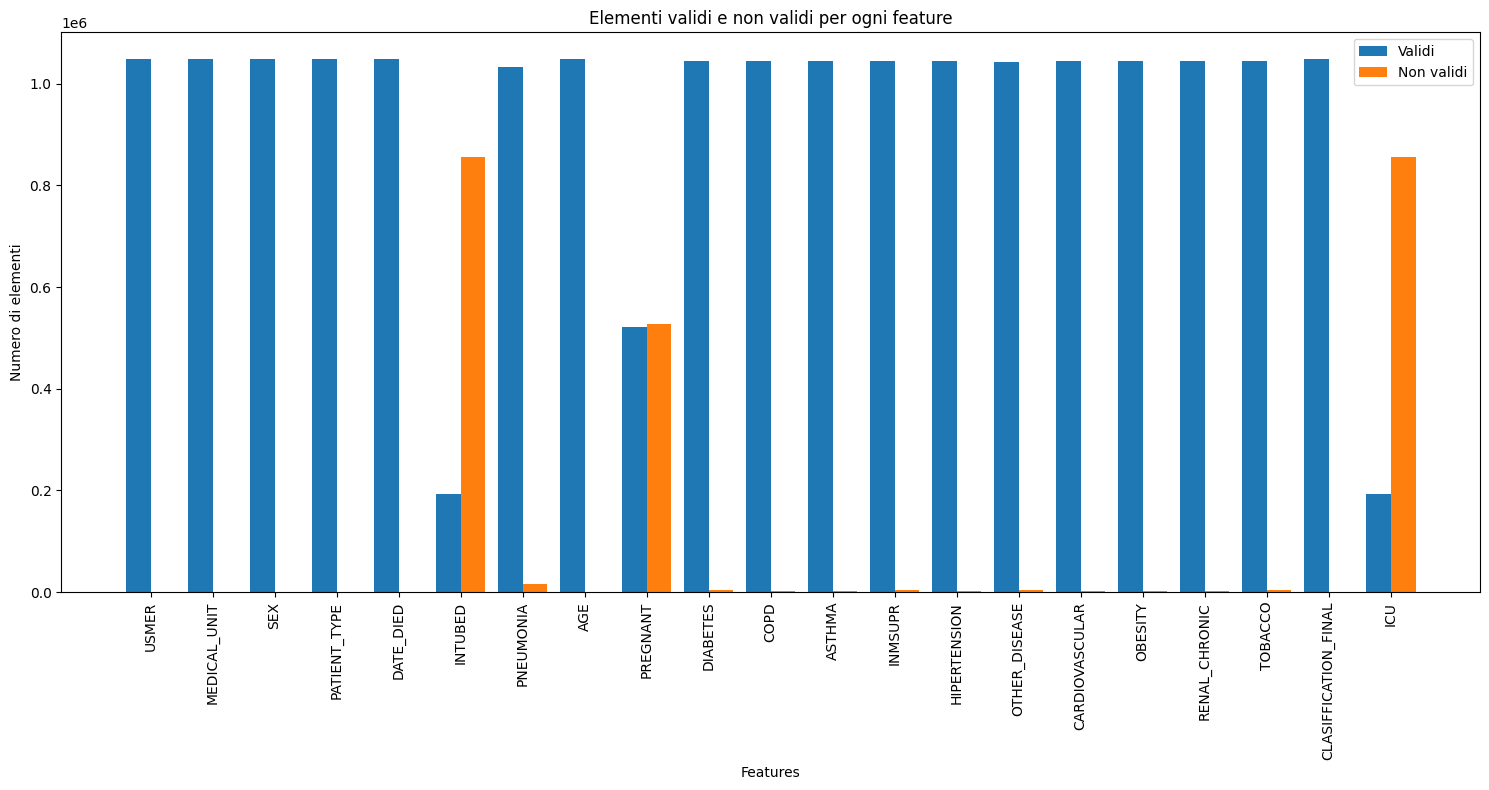

In [13]:
invalid_values = {97, 98, 99}

valid_counts = []
invalid_counts = []

for col in data.columns:
    valid_count = data[col].apply(lambda x: x not in invalid_values).sum()
    invalid_count = data[col].apply(lambda x: x in invalid_values).sum()
    valid_counts.append(valid_count)
    invalid_counts.append(invalid_count)

# Stampo il grafico dei dati ottenuti
x = np.arange(len(data.columns))
width = 0.4

# Definisco alcune proprietà del grafico
fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width/2, valid_counts, width, label='Validi')
rects2 = ax.bar(x + width/2, invalid_counts, width, label='Non validi')

ax.set_xlabel('Features')
ax.set_ylabel('Numero di elementi')
ax.set_title('Elementi validi e non validi per ogni feature')
ax.set_xticks(x)
ax.set_xticklabels(data.columns, rotation=90)
ax.legend()

fig.tight_layout()

plt.show()

Dal seguente grafico si nota come tre feature in particolare (INTUBED, PREGNANT e ICU) abbiano un gran numero di dati assenti, che verranno gestiti nella sezione successiva.

Un'altra statistica interessante riguarda la distribuzione del numero di pazienti vivi e morti, come possiamo vedere nella tabella di seguito la maggior parte dei pazienti sono vivi e ci sono diversi valori anomali, in particolare la prima informazione risulta importante poiché un tale sbilanciamento dei dati potrebbe creare un effetto negativo nelle prestazioni del modello.

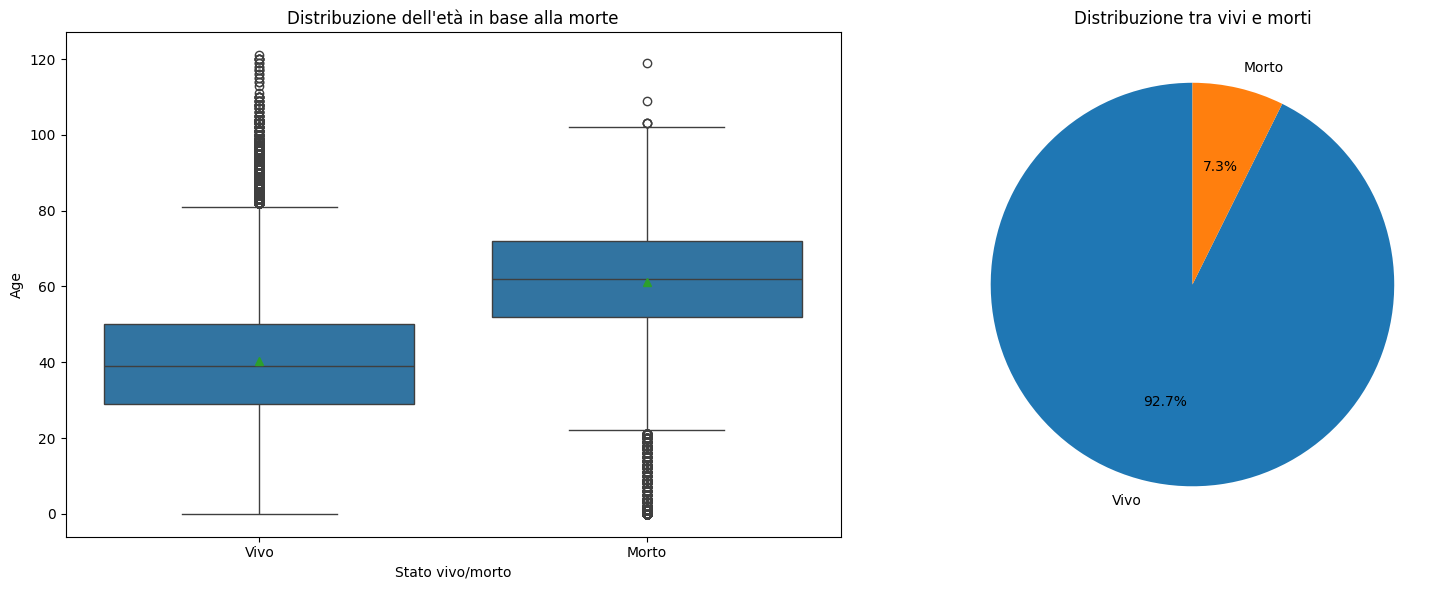

In [14]:
death_distr = data[["DATE_DIED", "AGE"]].copy()

# Converto la colonna DATE_DIED in un formato datetime per poterla utilizzare nel grafico !!!
death_distr.loc[death_distr.DATE_DIED != '9999-99-99', 'DATE_DIED'] = 'Morto'
death_distr.loc[death_distr.DATE_DIED == '9999-99-99', 'DATE_DIED'] = 'Vivo'

# Boxplot per l'età in base alla morte
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
death_distr = death_distr.sample(frac=1)
sns.boxplot(x='DATE_DIED', y='AGE', data=death_distr, showmeans=True, ax=axs[0])
axs[0].set_title('Distribuzione dell\'età in base alla morte')
axs[0].set_xlabel('Stato vivo/morto')
axs[0].set_ylabel('Age')

# Distribuzione dei dati tra vivi e morti
death_distr['DATE_DIED'].value_counts().plot(kind='pie', labels=['Vivo', 'Morto'], autopct='%1.1f%%', startangle=90, title='Distribuzione tra vivi e morti', ax=axs[1])
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

È interessante inoltre vedere la distribuzione del numero di pazienti vivi o morti rispetto alla loro età, come possiamo notare, il numero maggiore di pazienti morti lo troviamo intorno alla sessantina, numero comunque molto inferiore rispetto ai pazienti ancora vivi.

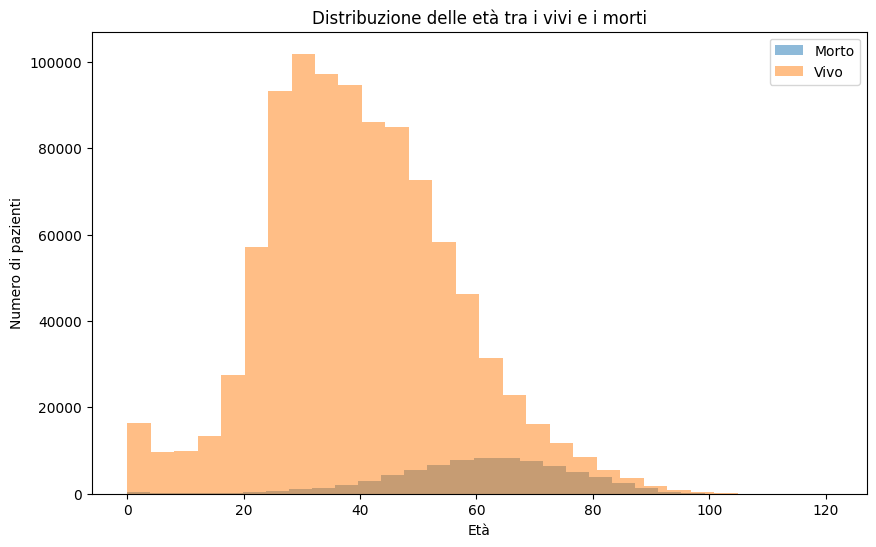

In [15]:
# Divido i pazienti vivi da quelli morti
died = data[data['DATE_DIED'] != '9999-99-99']
alive = data[data['DATE_DIED'] == '9999-99-99']

# Creo un istogramma basandomi sui dati dei due gruppi
plt.figure(figsize=(10,6))
plt.hist(died['AGE'], bins=30, alpha=0.5, label='Morto')
plt.hist(alive['AGE'], bins=30, alpha=0.5, label='Vivo')
plt.xlabel('Età')
plt.ylabel('Numero di pazienti')
plt.title('Distribuzione delle età tra i vivi e i morti')
plt.legend(loc='upper right')
plt.show()


Ad influire sulla sopravvivenza o meno della persona, oltre all'età c'è sicuramente la struttura in cui è stata ospitata, seguono quindi due grafici che mostrano il numero di persone vive e morte in ogni unità medica e la loro distribuzione per età:

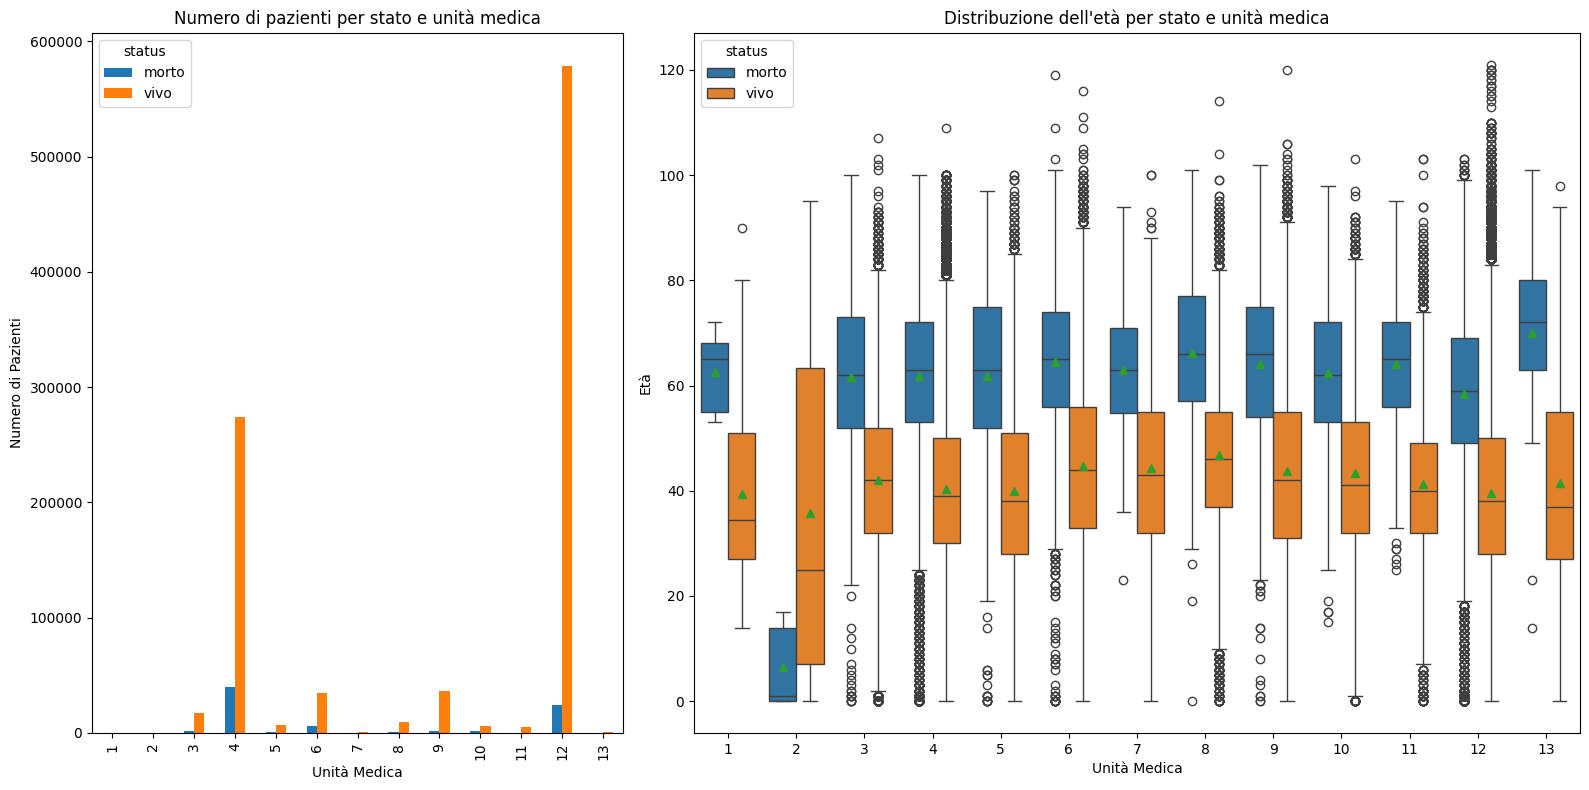

In [16]:
# Array che definisce lo stato di ogni paziente
data['status'] = data['DATE_DIED'].apply(lambda x: 'vivo' if x == '9999-99-99' else 'morto')

# Creo una griglia per i subplot (utilizzo GridSpec siccome i ratio dei due grafici sono diversi)
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 5])  

# Istogramma della sopravvivenza per ogni unità medica
ax0 = plt.subplot(gs[0])
data.groupby(['MEDICAL_UNIT', 'status']).size().unstack().plot(kind='bar', ax=ax0)
ax0.set_title('Numero di pazienti per stato e unità medica')
ax0.set_xlabel('Unità Medica')
ax0.set_ylabel('Numero di Pazienti')

# Boxplot dell'età per ogni stato e unità medica
ax1 = plt.subplot(gs[1])
sns.boxplot(x='MEDICAL_UNIT', y='AGE', hue='status',showmeans=True, data=data, ax=ax1)
ax1.set_title('Distribuzione dell\'età per stato e unità medica')
ax1.set_xlabel('Unità Medica')
ax1.set_ylabel('Età')

plt.tight_layout()
plt.show()

# Droppo la colonna di utility generata
data.drop(columns=['status'], inplace=True)

Dalla prima immagine si vede chiaramente che le unità 4 e 12 hanno numero di pazienti nettamente superiore alle altre unità, e allo stesso tempo anche  As can be seen from the patients who went to medical units 4 and 12, as the medical unit improves, survival rates increase and deaths decrease.(etc. 4= Cottage hospital, 12= Hospital)
The median values ​​of people who died and lived, who went to different medical units, do not change that much. Here we see that survival is proportional to age.

Un'ultima statistica interessante riguarda il numero di maschi e femmine, come possiamo vedere dal primo grafico entrambe le parti si avvicinano molto al 50%. Il secondo grafico invece mostra il numero di valori assenti nella feature PREGNANT per ogni sesso, da questo possiamo notare che pressochè tutti i valori assenti riguardano maschi, e che quindi possiamo considerarli come dei "no" poichè i maschi non possono rimanere incinta, questa analisi verrà trattata meglio nella sezione successiva.

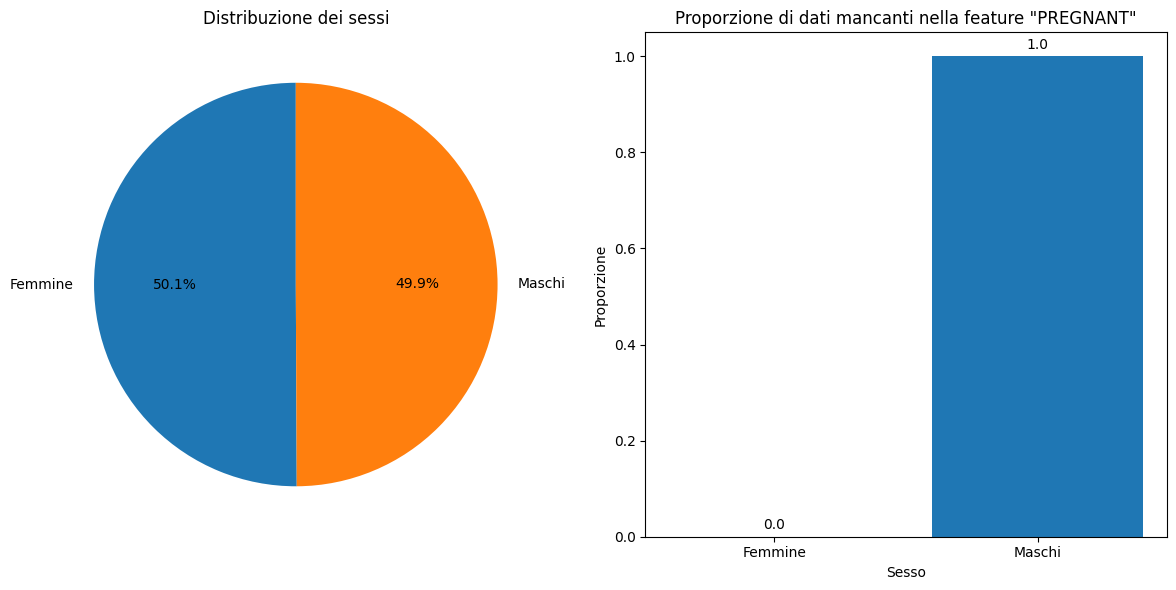

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Grafico a torta per la distribuzione dei sessi
data['SEX'].value_counts().plot(kind='pie', labels=['Femmine', 'Maschi'], autopct='%1.1f%%', startangle=90, ax=axs[0])
axs[0].set_title('Distribuzione dei sessi')
axs[0].set_ylabel('')

# Grafico a torta per la distribuzione dei pazienti vivi e morti
total_female = len(data[data['SEX'] == 1])
total_male = len(data[data['SEX'] == 2])

missing_female = len(data[(data['SEX'] == 1) & data['PREGNANT'].isin([97, 99])])
missing_male = len(data[(data['SEX'] == 2) & data['PREGNANT'].isin([97, 99])])

missing_female_prop = missing_female / total_female
missing_male_prop = missing_male / total_male

bars = axs[1].bar(['Femmine', 'Maschi'], [missing_female_prop, missing_male_prop])

# Aggiungo i valori sopra le barre
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

axs[1].set_xlabel('Sesso')
axs[1].set_ylabel('Proporzione')
axs[1].set_title('Proporzione di dati mancanti nella feature "PREGNANT"')

plt.tight_layout()
plt.show()


# Parte 3 - Preparazione dei Dati
In questa parte andrò a modificare i dati all'interno del dataframe, eliminando dati superflui o incompleti e ad ottimizzare la memoria.

Siccome le colonne INTUBED e ICU hanno per la maggior parte dei record valori assenti, e non sostituibili con qualche tecnica, vengono eliminate dal dataframe

In [18]:
print(data.INTUBED.value_counts())
print(data.ICU.value_counts())
data.drop(columns=["INTUBED","ICU"], inplace=True)

INTUBED
97    848544
2     159050
1      33656
99      7325
Name: count, dtype: int64
ICU
97    848544
2     175685
1      16858
99      7488
Name: count, dtype: int64


Della feature DATE_DIED, non ci importa la data di decesso o meno della persona, quindi possiamo convertirlo in un binario 1=vivo, 2=morto, sostituendo la colonna DATE_DIED con ALIVE

In [19]:
data["ALIVE"] = [0 if date=="9999-99-99" else 1 for date in data.DATE_DIED] # CHANGED FOR XGBOOST!!!
data.drop(columns=["DATE_DIED"], inplace=True)

Riguardo alla feature PREGNANT, come evidenziato nella sezione precedente, numerosi valori sono identificati come assenti, e questi appartengono principalmente a maschi, per questo motivo possiamo immetergli un valore PREGNANT uguale a 2 (False), mentre i pochi valori assenti rimanenti nei record con sesso femminile possiamo eliminarli siccome non sono un numero importante:

In [20]:
male_pregnant = data.loc[data.SEX == 2, 'PREGNANT'].value_counts()
female_pregnant = data.loc[data.SEX == 1, 'PREGNANT'].value_counts()
print(f"Male pregnants:\n{male_pregnant}\n")
print(f"Female pregnants:\n{female_pregnant}\n")

# Elimino i pochi record con sesso femminile senza informazioni sulla gravidanza
data = data[~((data.SEX == 1) & (data.PREGNANT != 1) & (data.PREGNANT != 2))]

# Converto tutti i record con sesso maschile in 2 (non incinta)
data = data.replace({'PREGNANT': {97: 2, 98: 2, 99: 2}})


Male pregnants:
PREGNANT
97    523511
Name: count, dtype: int64

Female pregnants:
PREGNANT
2     513179
1       8131
98      3754
Name: count, dtype: int64



Siccome la nostra analisi si basa sul capire quanto è critica la situazione di un paziente possiamo raggruppare le varie CLASSIFICATION_FINAL in due categorie, che andranno a rappresentare malato e non malato: !!!

In [21]:
data.CLASIFFICATION_FINAL = data.CLASIFFICATION_FINAL.replace([1,2,3], 1)
data.CLASIFFICATION_FINAL = data.CLASIFFICATION_FINAL.replace([4,5,6,7], 2)

Siccome esistono ancora alcuni record con valori assenti e sono una quantità minima, eliminiamo i record con valori tra 97 e 99. Non andiamo ad eseguire operazioni per provare a sostituire i valori assenti, poiche sono dati non riproducibili statisticamente e rischierebbe di peggiorare le prestazioni del modello finale.

In [22]:
print(f"Numero di record con feature tra 97 e 99: {data.apply(lambda col: col.isin([97, 98, 99]).sum()).sum()}")
data = data[~data.isin([97, 98, 99]).any(axis=1)]
print("Shape finale del dataset:", data.shape)

Numero di record con feature tra 97 e 99: 47332
Shape finale del dataset: (1021655, 19)


Andiamo ora invece ad analizzare i valori dei dati, in modo da capire se possiamo risparmiare memoria cambiando il tipo di dato a qualche feature.

In [23]:
for i in data.columns:
    print(i,": ",len(data[i].unique()))

USMER :  2
MEDICAL_UNIT :  13
SEX :  2
PATIENT_TYPE :  2
PNEUMONIA :  2
AGE :  118
PREGNANT :  2
DIABETES :  2
COPD :  2
ASTHMA :  2
INMSUPR :  2
HIPERTENSION :  2
OTHER_DISEASE :  2
CARDIOVASCULAR :  2
OBESITY :  2
RENAL_CHRONIC :  2
TOBACCO :  2
CLASIFFICATION_FINAL :  2
ALIVE :  2


Contando il numero di dati diversi all'interno delle varie features, possiamo notare che, esclusa DATE_DIED, tutte le feature hanno un numero molto contenuto di valori, per questo motivo possiamo raggrupparli attraverso la tipologia di dato category.

In [24]:
data['USMER'] = data['USMER'].astype('category')
data['MEDICAL_UNIT'] = data['MEDICAL_UNIT'].astype('category')
data['SEX'] = data['SEX'].astype('category')
data['PATIENT_TYPE'] = data['PATIENT_TYPE'].astype('category')
data['PNEUMONIA'] = data['PNEUMONIA'].astype('category')
data['PREGNANT'] = data['PREGNANT'].astype('category')
data['DIABETES'] = data['DIABETES'].astype('category')
data['COPD'] = data['COPD'].astype('category')
data['ASTHMA'] = data['ASTHMA'].astype('category')
data['INMSUPR'] = data['INMSUPR'].astype('category')
data['HIPERTENSION'] = data['HIPERTENSION'].astype('category')
data['OTHER_DISEASE'] = data['OTHER_DISEASE'].astype('category')
data['CARDIOVASCULAR'] = data['CARDIOVASCULAR'].astype('category')
data['OBESITY'] = data['OBESITY'].astype('category')
data['RENAL_CHRONIC'] = data['RENAL_CHRONIC'].astype('category')
data['TOBACCO'] = data['TOBACCO'].astype('category')
data['CLASIFFICATION_FINAL'] = data['CLASIFFICATION_FINAL'].astype('category')
data['ALIVE'] = data['ALIVE'].astype('category')

In [25]:
final_size = data.memory_usage(deep=True).sum()/1024**2

saved_memory = initial_size - final_size
saved_memory_percentage = (saved_memory / initial_size) * 100

print(f"Quantità di memoria risparmiata: {saved_memory:.2f} MB ({saved_memory_percentage:.2f}%)")

Quantità di memoria risparmiata: 193.87 MB (85.41%)


Osservando lo stato delle features possiamo vedere come le uniche due che hanno un dominio diverso dalle altre sono: AGE e MEDICAL_UNIT, perciò andiamo a normalizzarle utilizzando una tra le due funzioni di normalizzazione

In [26]:
# Utilizzo StandardScaler per normalizzare i dati (opzione 1)
scaler = StandardScaler()
data.AGE = scaler.fit_transform(data.AGE.values.reshape(-1,1))

In [27]:
# Using MinMaxScaler per normalizzare i dati (opzione 2)
scaler = MinMaxScaler()
data.AGE = scaler.fit_transform(data.AGE.values.reshape(-1,1))

Infine attraverso una matrice delle correlazioni, possiamo vedere alcune correlazioni tra le variabili del dataframe:

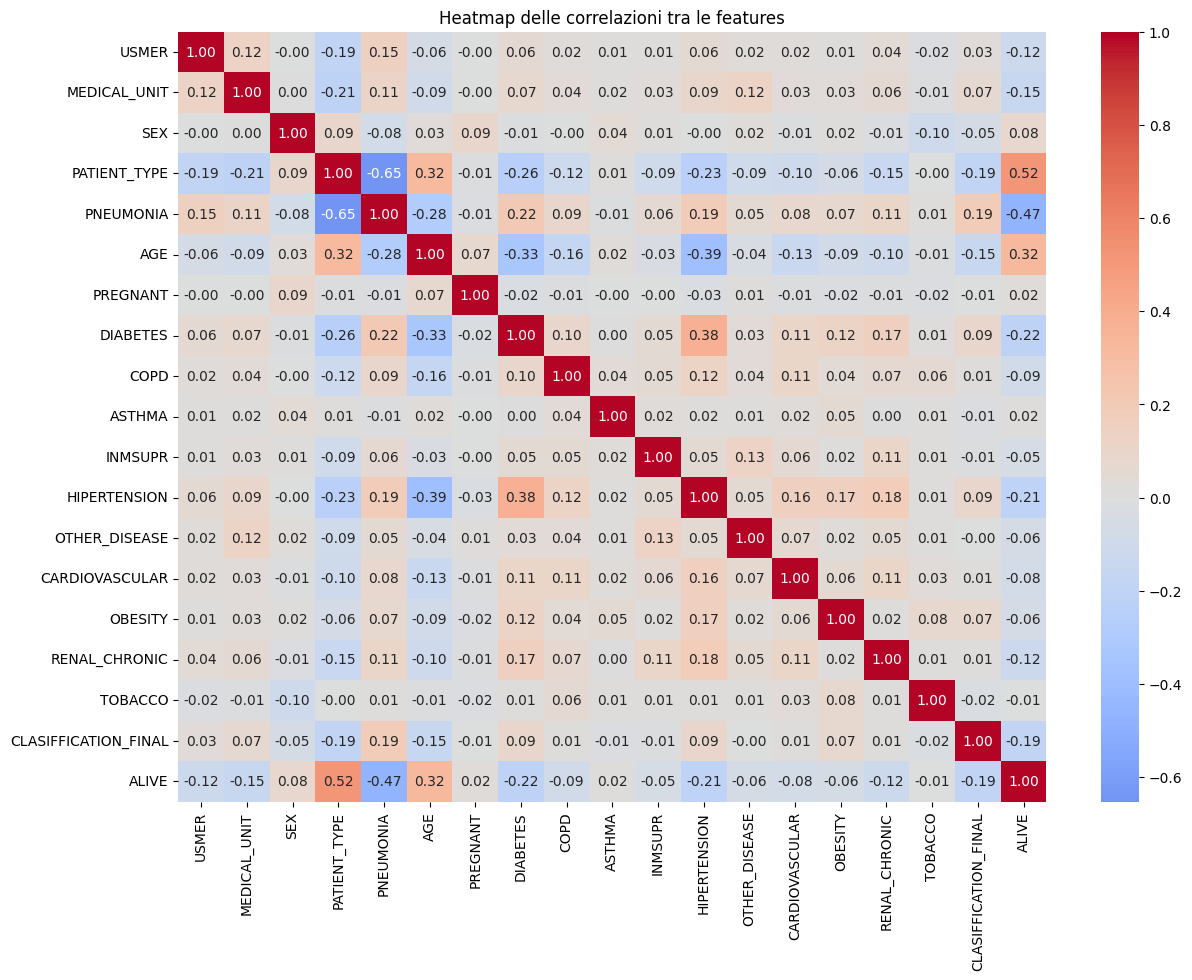

In [28]:
# Heatmap delle correlazioni tra le features
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Heatmap delle correlazioni tra le features')
plt.show()

In particolare notiamo che:
- ETA ha una leggera influenza sullo stato ALIVE (come si poteva notare anche dal grafico della prima sezione)
- PATIENT_TYPE ha una forte correlazione con ALIVE, probabilmente indica che pazienti trattati con più prirità hanno più probabilità di sopravvivenza
- La PNEUMONIA, DIABETE e HIPERTENSIONE, hanno una notevole correlazione inversa ad ALIVE.

# 4 - Addestramento e Validazione dei Modelli

Gestisco le variabili categorice attraverso un one-hot encode, abilitando il parametro drop_first in modo da evitare **multicollinearità**!!!, e  normalizzo le variabili con una scala di valori molto diversa dagli altri, in questo caso solamente Age.

In [35]:
df = data.copy()
df.head()

# Eseguo il one hot encoding per le colonne categoriche
columns_to_encode = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 
                     'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 
                     'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL']

df = pd.get_dummies(df, columns=columns_to_encode)

x = df.drop(columns="ALIVE")
y = df["ALIVE"]

df.head()

,AGE,ALIVE,USMER_1,USMER_2,MEDICAL_UNIT_1,MEDICAL_UNIT_2,MEDICAL_UNIT_3,MEDICAL_UNIT_4,MEDICAL_UNIT_5,MEDICAL_UNIT_6,...,CARDIOVASCULAR_1,CARDIOVASCULAR_2,OBESITY_1,OBESITY_2,RENAL_CHRONIC_1,RENAL_CHRONIC_2,TOBACCO_1,TOBACCO_2,CLASIFFICATION_FINAL_1,CLASIFFICATION_FINAL_2
0,0.537190,1,False,True,True,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
1,0.595041,1,False,True,True,False,False,False,False,False,...,False,True,True,False,True,False,False,True,False,True
2,0.454545,1,False,True,True,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
3,0.438017,1,False,True,True,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True
4,0.561983,1,False,True,True,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False


In [36]:
# Generazione dei dati di training e test
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=42)

In [37]:
x.head()

,AGE,USMER_1,USMER_2,MEDICAL_UNIT_1,MEDICAL_UNIT_2,MEDICAL_UNIT_3,MEDICAL_UNIT_4,MEDICAL_UNIT_5,MEDICAL_UNIT_6,MEDICAL_UNIT_7,...,CARDIOVASCULAR_1,CARDIOVASCULAR_2,OBESITY_1,OBESITY_2,RENAL_CHRONIC_1,RENAL_CHRONIC_2,TOBACCO_1,TOBACCO_2,CLASIFFICATION_FINAL_1,CLASIFFICATION_FINAL_2
0,0.537190,False,True,True,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
1,0.595041,False,True,True,False,False,False,False,False,False,...,False,True,True,False,True,False,False,True,False,True
2,0.454545,False,True,True,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False
3,0.438017,False,True,True,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,False,True
4,0.561983,False,True,True,False,False,False,False,False,False,...,False,True,False,True,False,True,False,True,True,False


In [44]:
lr = LogisticRegression()
lr.fit(train_x, train_y)
print("Logistic Regression Accuracy: ",lr.score(test_x, test_y))

Logistic Regression Accuracy:  0.9381444812583504


In [43]:
# Utilizzo del modello random forest
rfc = RandomForestClassifier()
rfc.fit(train_x, train_y)

# Predict on test data
y_pred = rfc.predict(test_x)

accuracy = rfc.score(test_x, test_y)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 93.17%


In [42]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Let's suppose X, y are your features and target
# X, y = load_your_data()

# Apply label encoder
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss') # to avoid future warnings
xgb.fit(train_x, train_y)

r2_score = xgb.score(test_x, test_y)
print(f'R^2 Score: {r2_score:.2f}')
# Calculate the accuracy score
y_pred = xgb.predict(test_x)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

/home/giacomo/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


R^2 Score: 0.94
Accuracy: 93.97%


In [45]:
# Utilizzo del modello xgboost
xgb = XGBClassifier(n_estimators = 200, learning_rate=0.1)
xgb.fit(train_x, train_y)

y_pred = xgb.predict(test_x)

r2_score = xgb.score(test_x, test_y)
print(f'R^2 Score: {r2_score:.2f}')


R^2 Score: 0.94


In [48]:
# Uso un decision tree
dt=DecisionTreeClassifier(random_state=42)
dt.fit(train_x, train_y)
print("Decision Tree Score: ",dt.score(test_x, test_y))

Decision Tree Score:  0.9298735874634784


In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_x)

# Apply transform to both the training set and the test set.
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# Convert labels to categorical one-hot encoding
train_y_categorical = to_categorical(train_y)
test_y_categorical = to_categorical(test_y)

# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=train_x.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(train_y_categorical.shape[1], activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_x, train_y_categorical, epochs=50, batch_size=32, verbose=1)

# Evaluate on test data
score = model.evaluate(test_x, test_y_categorical, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]*100:.2f}%')


2024-07-14 12:11:14.455703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 12:11:14.572950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 12:11:14.605664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 12:11:14.830960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 12:11:16.098538: W tensorflow/compiler/tf2

Epoch 1/50


I0000 00:00:1720951880.264581   42183 service.cc:146] XLA service 0x7f323c009af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720951880.264639   42183 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-07-14 12:11:20.319310: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-14 12:11:20.513648: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-07-14 12:11:20.601230: W external/local_xla/xla/stream_executor/gpu/redzone_allocator_kernel_cuda.cc:136] NOT_FOUND: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /usr/bin/ptxas, /home/giacomo/.vscode-server/bin/f1e16e1e6214d7c44d078b1f0607b2388f29d729/bin/remote-cli/ptxas, /home/giacomo/.local/bin/ptxas, /usr/local/sbin/pt

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/giacomo/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/giacomo/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/giacomo/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/giacomo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/giacomo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/giacomo/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/giacomo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/giacomo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/giacomo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_29697/388839496.py", line 30, in <module>

  File "/home/giacomo/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/giacomo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/giacomo/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /usr/bin/ptxas, /home/giacomo/.vscode-server/bin/f1e16e1e6214d7c44d078b1f0607b2388f29d729/bin/remote-cli/ptxas, /home/giacomo/.local/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /usr/lib/wsl/lib/ptxas, /mnt/c/Program Files/Common Files/Oracle/Java/javapath/ptxas, /mnt/c/Program Files (x86)/Common Files/Oracle/Java/java8path/ptxas, /mnt/c/Program Files (x86)/Common Files/Oracle/Java/javapath/ptxas, /mnt/c/Windows/system32/ptxas, /mnt/c/Windows/ptxas, /mnt/c/Windows/System32/Wbem/ptxas, /mnt/c/Windows/System32/WindowsPowerShell/v1.0/ptxas, /mnt/c/Windows/System32/OpenSSH/ptxas, /mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common/ptxas, /mnt/c/Program Files/NVIDIA Corporation/NVIDIA NvDLISR/ptxas, /mnt/c/Program Files/dotnet/ptxas, /mnt/c/Program Files/Git/cmd/ptxas, /mnt/c/Users/giaco/AppData/Local/Programs/Python/Python312/Scripts/ptxas, /mnt/c/Users/giaco/AppData/Local/Programs/Python/Python312/ptxas, /mnt/c/Users/giaco/AppData/Local/Microsoft/WindowsApps/ptxas, /mnt/c/Users/giaco/AppData/Local/Programs/Microsoft VS Code/bin/ptxas, /mnt/c/Users/giaco/.dotnet/tools/ptxas, /snap/bin/ptxas, /home/giacomo/.vscode-server/bin/f1e16e1e6214d7c44d078b1f0607b2388f29d729/bin/remote-cli/ptxas, /home/giacomo/.local/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /usr/lib/wsl/lib/ptxas, /mnt/c/Program Files/Common Files/Oracle/Java/javapath/ptxas, /mnt/c/Program Files (x86)/Common Files/Oracle/Java/java8path/ptxas, /mnt/c/Program Files (x86)/Common Files/Oracle/Java/javapath/ptxas, /mnt/c/Windows/system32/ptxas, /mnt/c/Windows/ptxas, /mnt/c/Windows/System32/Wbem/ptxas, /mnt/c/Windows/System32/WindowsPowerShell/v1.0/ptxas, /mnt/c/Windows/System32/OpenSSH/ptxas, /mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common/ptxas, /mnt/c/Program Files/NVIDIA Corporation/NVIDIA NvDLISR/ptxas, /mnt/c/Program Files/dotnet/ptxas, /mnt/c/Program Files/Git/cmd/ptxas, /mnt/c/Users/giaco/AppData/Local/Programs/Python/Python312/Scripts/ptxas, /mnt/c/Users/giaco/AppData/Local/Programs/Python/Python312/ptxas, /mnt/c/Users/giaco/AppData/Local/Microsoft/WindowsApps/ptxas, /mnt/c/Users/giaco/AppData/Local/Programs/Microsoft VS Code/bin/ptxas, /mnt/c/Users/giaco/.dotnet/tools/ptxas, /snap/bin/ptxas, /usr/local/cuda-12.3/bin/ptxas, /usr/local/cuda/bin/ptxas, /home/giacomo/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/giacomo/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_1353]

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Gestisco le variabili categorice attraverso un one-hot encode, abilitando il parametro drop_first in modo da evitare **multicollinearità** !!!

In [ ]:
#data = pd.get_dummies(data,columns=["USMER", "MEDICAL_UNIT", "SEX", "PNEUMONIA", "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO"],drop_first=True)

In [ ]:
print(data.columns)
print(data.shape)
data_part = data[:200000]

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE',
       'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL', 'DIED'],
      dtype='object')
(1021655, 19)


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb

# Separate features and target variable
X = data_part.drop('CLASIFFICATION_FINAL', axis=1)
y = data_part['CLASIFFICATION_FINAL']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing: Label encode categorical variables and scale numerical variables
for col in categorical_cols:
    lbl = LabelEncoder()
    X[col] = lbl.fit_transform(X[col])

# Scaling numerical features
for col in numerical_cols:
    scl = StandardScaler()
    X[col] = scl.fit_transform(X[col].values.reshape(-1, 1))

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and their respective hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': xgb.XGBClassifier(tree_method='hist', random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

best_estimators = {}
best_scores = {}

# Perform GridSearchCV for each model
for model_name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

# Evaluate the best model from each grid search on the test set
for model_name, best_estimator in best_estimators.items():
    y_pred = best_estimator.predict(X_test)
    y_pred = le.inverse_transform(y_pred) # inverse transform the predicted labels back to original
    accuracy = accuracy_score(le.inverse_transform(y_test), y_pred) # compare with original test labels
    conf_matrix = confusion_matrix(le.inverse_transform(y_test), y_pred)
    print(f"\n{model_name} Test Set Evaluation:")
    print(f"Accuracy: {accuracy}")
    print('Confusion Matrix:')
    print(conf_matrix)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters for Logistic Regression: {'C': 10}
Best cross-validation score for Logistic Regression: 0.6716375


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score for Random Forest: 0.68839375


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best cross-validation score for Gradient Boosting: 0.688525

Logistic Regression Test Set Evaluation:
Accuracy: 0.668875
Confusion Matrix:
[[    0     0    67     0     0     0    12]
 [    0     0   251     0     0     1     5]
 [    0     0 25907     0     0    26   658]
 [    0     0    20     0     0     0    20]
 [    0     0  1157     0     0     6    51]
 [    0     0  8493     0     0   116    98]
 [    0     0  2376     0     0     4   732]]

Random Forest Test Set Evaluation:
Accuracy: 0.68735
Confusion Matrix:
[[    0     0    61     0     0     1    17]
 [    0     0   256     0     0     0     1]
 [    0     0 25237     0     0   512   842]
 [    0     0    25     0     0     0    15]
 [    0     0  1092     0     0    57    65]
 [    0     0  7617     0     0   925   165]
 [    0     0  1780     0     0     0  1332]]

Gradient Boosting Test Set Evaluation:
Accuracy: 0.6872
Co

## Trying DNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.max() + 1, activation='softmax')) # Use 'softmax' for multi-class classification problems

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluate model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f'Training Accuracy: {train_acc*100}')
print(f'Testing Accuracy: {test_acc*100}')


2024-07-11 17:23:38.226572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 17:23:40.725772: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 17:23:43.845775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-11 17:23:43.855158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

Epoch 1/10
5000/5000 [==============================] - 12s 2ms/step - loss: 0.8027 - accuracy: 0.6813 - val_loss: 0.7831 - val_accuracy: 0.6851
Epoch 2/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.7793 - accuracy: 0.6856 - val_loss: 0.7804 - val_accuracy: 0.6844
Epoch 3/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.7770 - accuracy: 0.6866 - val_loss: 0.7792 - val_accuracy: 0.6862
Epoch 4/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.7757 - accuracy: 0.6870 - val_loss: 0.7743 - val_accuracy: 0.6867
Epoch 5/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.7747 - accuracy: 0.6867 - val_loss: 0.7747 - val_accuracy: 0.6862
Epoch 6/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.7738 - accuracy: 0.6874 - val_loss: 0.7730 - val_accuracy: 0.6870
Epoch 7/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.7737 - accuracy: 0.6865 - val_loss: 0.7738 - val_accuracy